<h1 style = "color:red;">Trafik Kazalarında Yaralanma Şiddetinin Tahmini</h1>

<h4 style="color: #000000; font-weight: bold;">Proje Amacı:</h4> Chicago’da meydana gelen trafik kazalarıyla ilgili bilgileri inceleyerek bir kazada insanların ne kadar yaralanabileceğini önceden tahmin edebilmektir. Elimizde, her kaza için hava durumu, yol koşulları, kazanın gündüz mü gece mi yaşandığı, yolun kaç şeritli olduğu, kazanın bir kavşakta gerçekleşip gerçekleşmediği, hız sınırı, kaç aracın karıştığı ve kazanın türü gibi birçok detay bulunmaktadır. Bu bilgiler kullanılarak “Bu kazada yaralanma hafif mi olurdu, ağır mı olurdu, yoksa hiç yaralanma olmaz mıydı?” sorusuna cevap aranmaktadır. Böyle bir çalışma sayesinde kazaların sonuçlarını önceden tahmin etmek, tehlikeli durumları daha iyi anlamak ve ileride benzer şartlar oluştuğunda ne tür sonuçların ortaya çıkabileceğine dair daha güçlü öngörüler oluşturmak mümkündür. Bunun sonucunda güvenliği artırmaya yönelik daha doğru kararlar alınabilir; örneğin belirli bölgelerde hız sınırının düzenlenmesi, ışıklandırmanın iyileştirilmesi veya yol koşullarının kazalara etkisinin daha iyi anlaşılması gibi önemli çıkarımlar sağlanabilir.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RNG = 42
np.random.seed(RNG)

<h4 style="color: #000000; font-weight: bold;">2- Veri yükleme:</h4>

In [2]:
df = pd.read_csv("Traffic_Crashes.csv")

<h4 style="color: #000000; font-weight: bold;">2- Veri İnceleme (Exploratory Review):</h4>
Bu aşamada elimizdeki veri setini genel hatlarıyla tanımayı amaçlıyoruz. Bu yaptığımız verinin içinde neler olduğunu anlamak, hangi tür bilgilerin yer aldığını görmek, hangi sütunların önemli olabileceğini fark etmek için yapılan ilk gözlemdir. Bu bölümde veri setinin büyüklüğüne bakılır; yani kaç satır ve kaç sütun olduğu görülür. Her bir sütunun ne anlama geldiği anlaşılmaya çalışılır. Eksik bilgi olup olmadığına, tekrar eden satırlar bulunup bulunmadığına ve verilerin türlerinin doğru şekilde tanımlanıp tanımlanmadığına bakılır. Bu inceleme, ileride yapılacak tüm işlemler için bir temel oluşturur. Çünkü veriyi yeterince tanımazsak, doğru bir hazırlık, analiz veya modelleme yapamayız. Bu aşama sayesinde veri setinin yapısı, sorunları ve potansiyel kullanım şekilleri hakkında genel bir fikir sahibi oluruz.

In [3]:
print("Orijinal veri boyutu:", df.shape)
print("Sütun sayısı:", len(df.columns))

Orijinal veri boyutu: (300000, 48)
Sütun sayısı: 48


In [4]:
# İlk 5 satırı göster
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,98df5755b18bc25a67163bb832c0fd2b72c41631ef6e7d...,NaN,02/03/2025 06:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),...,1.0,0.0,1.0,0.0,6,2,2,41.904354,-87.721531,POINT (-87.721531234586 41.904353607338)
1,4e85802a19266b7c4c848561724da842d34a2509a4d931...,NaN,06/16/2022 01:50:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,1.0,0.0,0.0,0.0,1,5,6,41.800640,-87.620846,POINT (-87.620846187015 41.800640445503)
2,d747392bff241c36c7ecbc171143947f6b93896a72a4ce...,NaN,01/19/2024 06:11:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,CENTER TURN LANE,...,1.0,0.0,1.0,0.0,18,6,1,41.659126,-87.559433,POINT (-87.559432741943 41.659126189932)
3,54aa7076c5ff7e2667d07268186d95064cad67ffa84e89...,NaN,02/01/2025 01:00:00 PM,30,NO CONTROLS,NO CONTROLS,UNKNOWN,DAYLIGHT,REAR TO SIDE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,13,7,2,41.705506,-87.535139,POINT (-87.535139453239 41.7055064825)
4,ac3f58b20d6ca95846e085b053618467d967c51f68d2c1...,NaN,07/14/2025 08:45:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,8,2,7,41.850620,-87.632113,POINT (-87.632112683668 41.850620317342)


In [5]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                300000 non-null  object 
 1   CRASH_DATE_EST_I               19194 non-null   object 
 2   CRASH_DATE                     300000 non-null  object 
 3   POSTED_SPEED_LIMIT             300000 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         300000 non-null  object 
 5   DEVICE_CONDITION               300000 non-null  object 
 6   WEATHER_CONDITION              300000 non-null  object 
 7   LIGHTING_CONDITION             300000 non-null  object 
 8   FIRST_CRASH_TYPE               300000 non-null  object 
 9   TRAFFICWAY_TYPE                300000 non-null  object 
 10  LANE_CNT                       56674 non-null   float64
 11  ALIGNMENT                      300000 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [6]:
# Veri tipi özet
print("\n--- Veri tipi özet ---")
print(df.dtypes.value_counts())


--- Veri tipi özet ---
object     31
float64    11
int64       6
Name: count, dtype: int64


In [7]:
# ------------------------------------------
#MANTIKSAL TUTARLILIK KONTROLÜ (SANITY CHECK)
# ------------------------------------------
# Sayısal verilerdeki imkansız değerleri temizliyoruz.
print("\n--- Mantıksal Kontroller Yapılıyor ---")

# Hız sınırı kontrolü (0 ile 90 arası makul kabul edildi)
hatali_hiz_sayisi = df[(df['POSTED_SPEED_LIMIT'] < 0) | (df['POSTED_SPEED_LIMIT'] > 90)].shape[0]
if hatali_hiz_sayisi > 0:
    print(f"{hatali_hiz_sayisi} adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.")
    df = df[(df['POSTED_SPEED_LIMIT'] >= 0) & (df['POSTED_SPEED_LIMIT'] <= 90)]
else:
    print("Hız sınırları mantıksal aralıkta.")
# ------------------------------------------


--- Mantıksal Kontroller Yapılıyor ---
19 adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.


In [8]:
# Eksik değer analiz tablosu
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

eksik_df.head(50)

,eksik_sayisi,eksik_yuzdesi
WORKERS_PRESENT_I,299554,99.857658
WORK_ZONE_TYPE,298689,99.569306
WORK_ZONE_I,298223,99.413963
DOORING_I,297618,99.212283
PHOTOS_TAKEN_I,295278,98.432234
STATEMENTS_TAKEN_I,289818,96.612119
NOT_RIGHT_OF_WAY_I,288431,96.149756
CRASH_DATE_EST_I,280787,93.601595
LANE_CNT,243312,81.109137
HIT_AND_RUN_I,215016,71.676540


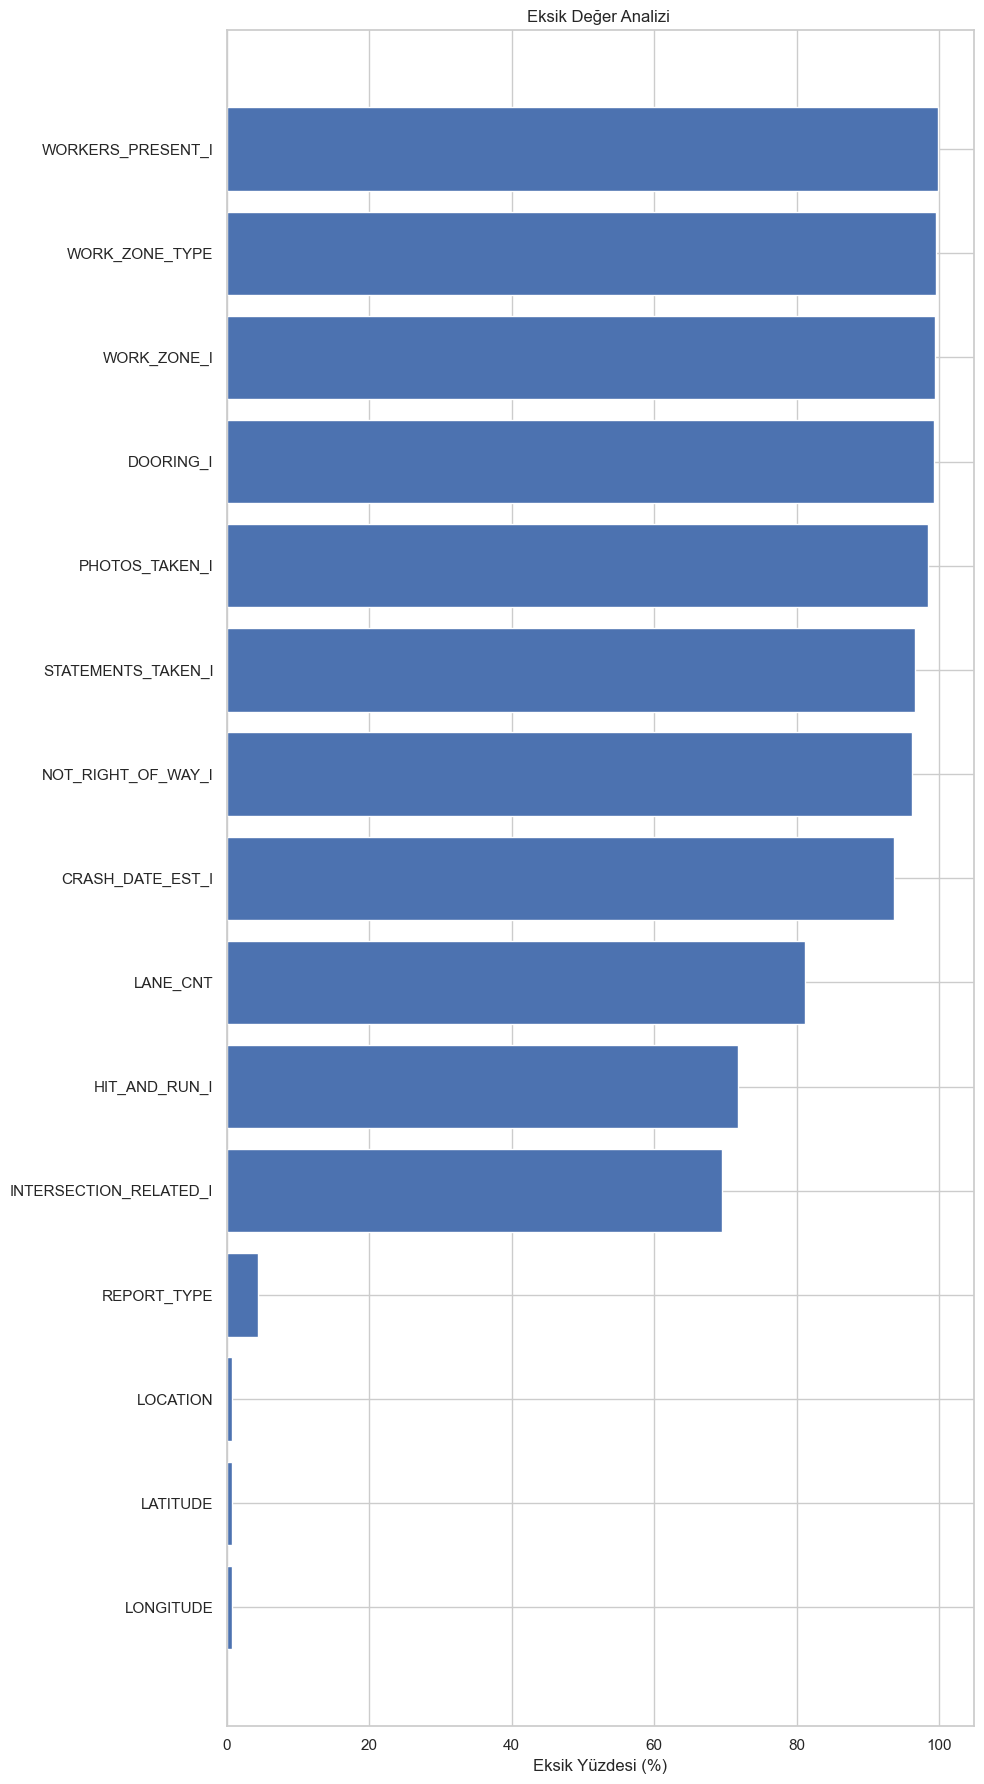

In [9]:
import matplotlib.pyplot as plt

# Eksik değer tablosu 
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

# --- GÖRSELLEŞTİRME ---
plt.figure(figsize=(10, 18))
plt.barh(eksik_df.head(15).index, eksik_df.head(15)['eksik_yuzdesi'])
plt.xlabel("Eksik Yüzdesi (%)")
plt.title("Eksik Değer Analizi ")
plt.gca().invert_yaxis()  # En yüksek değeri üstte göstermek için
plt.tight_layout()
plt.show()

In [10]:
df.nunique().sort_values(ascending=False).head(20)

CRASH_RECORD_ID                299981
DATE_POLICE_NOTIFIED           276882
CRASH_DATE                     262635
LOCATION                       146837
LATITUDE                       146832
LONGITUDE                      146830
STREET_NO                       10535
STREET_NAME                      1477
BEAT_OF_OCCURRENCE                276
INJURIES_NO_INDICATION             41
PRIM_CONTRIBUTORY_CAUSE            40
SEC_CONTRIBUTORY_CAUSE             40
POSTED_SPEED_LIMIT                 36
LANE_CNT                           27
CRASH_HOUR                         24
TRAFFICWAY_TYPE                    20
INJURIES_NON_INCAPACITATING        20
INJURIES_TOTAL                     20
TRAFFIC_CONTROL_DEVICE             19
FIRST_CRASH_TYPE                   18
dtype: int64

<h4 style="color: #000000; font-weight: bold;"> 4- Gereksiz Sütunların Silinmesi:</h4>
Bu sütunlar, çok fazla eksik değer içermeleri, modelleme sürecine anlamlı bir katkı sağlamamaları, bazıların coğrafi koordinatlardan oluşması ve analiz aşamasında gereksiz gürültü yaratma ihtimalleri nedeniyle veri setinden çıkarılır. Bu şekilde veri daha temiz, daha anlaşılır ve modelleme için daha uygun bir hale getirilmiş olur.

In [11]:
silinecek_sutunlar = [
    'WORKERS_PRESENT_I','DOORING_I','WORK_ZONE_TYPE','WORK_ZONE_I',
    'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','NOT_RIGHT_OF_WAY_I',
    'CRASH_DATE_EST_I','LANE_CNT','INTERSECTION_RELATED_I','HIT_AND_RUN_I',
    'LATITUDE','LONGITUDE','CRASH_RECORD_ID','CRASH_DATE','DATE_POLICE_NOTIFIED',
    'STREET_NO','STREET_DIRECTION','STREET_NAME','LOCATION','REPORT_TYPE', 'BEAT_OF_OCCURRENCE'
]

df.drop(columns=silinecek_sutunlar, inplace=True)
print("Veri boyutu:", df.shape)

Veri boyutu: (299981, 26)


<h4 style="color: #000000; font-weight: bold;"> 5-Yaralanma Sütunlarının Silinmesi (Data Leakage Önleme): </h4>
Bu aşamada, kazaların sonuçlarını doğrudan içeren yaralanma sütunları veri setinden çıkarılır. Çünkü bu bilgiler, tahmin etmeye çalıştığımız sonucun ta kendisidir. Eğer model bu sütunları görmeye devam ederse, tahmin sürecinde gerçek cevabı önceden öğrenmiş olur ve bu durum “veri sızıntısı” olarak adlandırılan hataya yol açar. Böyle bir durumda model gerçekte olduğundan çok daha başarılı görünür, ancak gerçek hayatta aynı performansı gösteremez. Bu nedenle yaralanma ile ilgili tüm sütunlar kaldırılarak, modelin yalnızca kazanın gerçekleştiği koşullara bakarak bağımsız bir şekilde tahmin yapması sağlanır. Bu işlem, modelin güvenilirliğini ve doğruluğunu artırmak için kritik bir adımdır.

In [12]:
# Yaralanma sütunlarını kaldırma (leakage engelleme)
leak_cols = [
    'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION','INJURIES_UNKNOWN'
]

df.drop(columns=[c for c in leak_cols if c in df.columns], inplace=True)
print("Veri boyutu:", df.shape)


Veri boyutu: (299981, 19)


<h4 style="color: #000000; font-weight: bold;"> 6- Hedef Değişkenin Belirlenmesi: </h4>
Bu aşamada, modelin tahmin etmeyi amaçlayacağı hedef değişken belirlenir. Projede amaç, bir trafik kazasında meydana gelen yaralanmanın şiddetini tahmin etmek olduğu için MOST_SEVERE_INJURY sütunu hedef olarak seçilir. Bu sütun, kazadaki yaralanmanın türünü içerir ve modelin öğrenmesi gereken temel bilgiyi temsil eder.

In [13]:
target = "MOST_SEVERE_INJURY"

X = df.drop(columns=[target])
y = df[target]


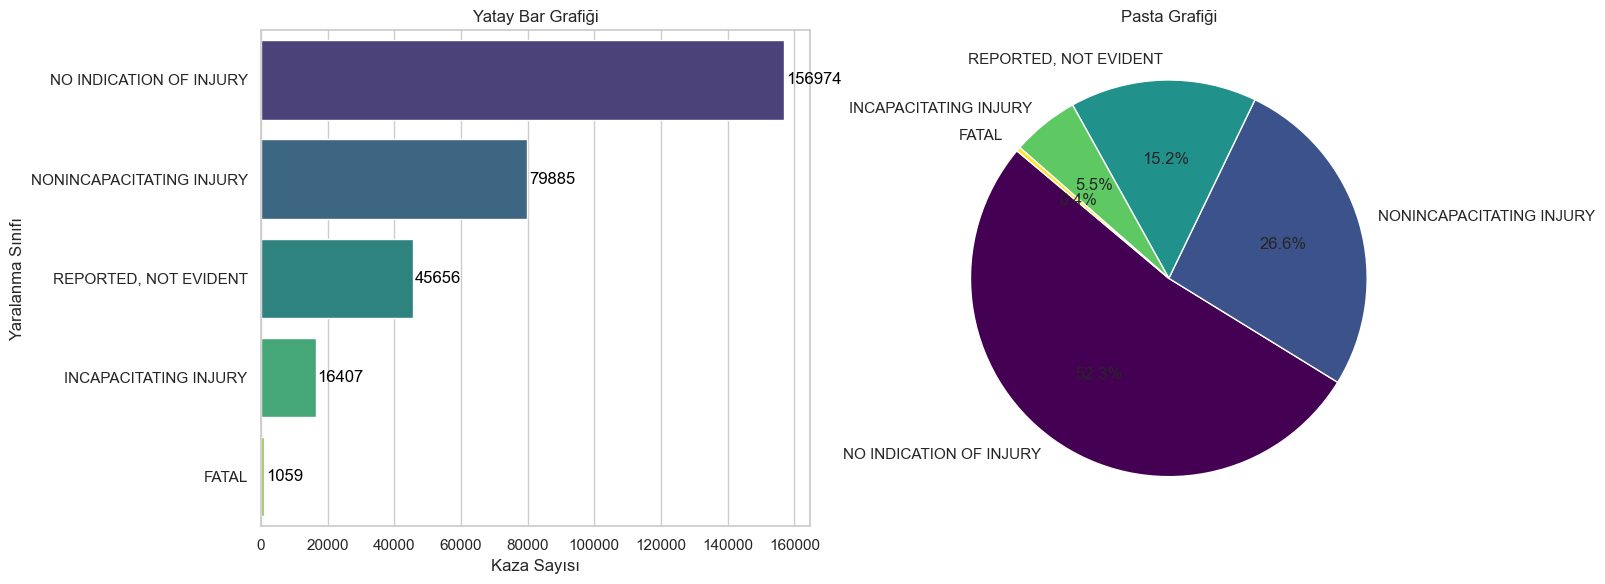

In [14]:
sayi = df[target].value_counts(dropna=False).sort_values(ascending=False)
etiketler = [str(i) if pd.notna(i) else 'NaN' for i in sayi.index]

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
barlar_yatay = sns.barplot(y=etiketler, x=sayi.values, palette="viridis")
for i, v in enumerate(sayi.values):
    barlar_yatay.text(v + 500, i, str(v), color='black', va='center')
plt.title("Yatay Bar Grafiği")
plt.xlabel("Kaza Sayısı")
plt.ylabel("Yaralanma Sınıfı")

plt.subplot(1, 2, 2)
plt.pie(sayi.values, labels=etiketler, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.viridis(np.linspace(0, 1, len(sayi))))
plt.title("Pasta Grafiği")
plt.tight_layout()
plt.show()

In [15]:
# ------------------------------------------
#SINIF DENGESİZLİĞİ KONTROLÜ
# ------------------------------------------
print(f"\n--- Hedef Değişken ({target}) Sınıf Dağılımı ---")
sinif_dagilimi = df[target].value_counts(normalize=True) * 100
print(sinif_dagilimi)

if sinif_dagilimi.max() > 80:
    print("\n[UYARI] Ciddi bir sınıf dengesizliği var. Model eğitiminde 'class_weight' veya SMOTE kullanılması önerilir.")
else:
    print("\nSınıf dağılımı kabul edilebilir düzeyde.")
# ------------------------------------------


--- Hedef Değişken (MOST_SEVERE_INJURY) Sınıf Dağılımı ---
MOST_SEVERE_INJURY
NO INDICATION OF INJURY     52.327981
NONINCAPACITATING INJURY    26.630020
REPORTED, NOT EVIDENT       15.219631
INCAPACITATING INJURY        5.469346
FATAL                        0.353022
Name: proportion, dtype: float64

Sınıf dağılımı kabul edilebilir düzeyde.


<h4 style="color: #000000; font-weight: bold;"> 7- Train/Test Ayırma: </h4>
Veri setinde yalnızca temel temizlik işlemleri yapıldıktan sonra, yani veriye herhangi bir öğrenme veya çıkarım sağlayacak işlem uygulanmadan önce train/test ayırma işlemi erken bir aşamada gerçekleştirilir. Bu şekilde veri sızıntısı engellenmiş olur. Böylece daha sonra yapılacak tüm işlemler yalnızca eğitim verisine dayanarak öğrenilir ve test verisi tamamen bağımsız kalır.

In [16]:
# 1) %20 test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2) %80 içinden %6.25 → %5 validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.0625,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (224985, 18)
Val: (14999, 18)
Test: (59997, 18)


<h4 style="color: #000000; font-weight: bold;"> 8- Keşifsel Veri Analizi (EDA) </h4>
Keşifsel Veri Analizi, veri setini daha yakından tanımamızı sağlayan önemli bir aşamadır. Bu bölümde amaç, verilerin içerdiği ilişki ve örüntüleri görselleştirmeler ve istatistiksel özetler üzerinden keşfetmektir. Hangi değişkenlerin hangi değerlerde yoğunlaştığını, uç değerlerin olup olmadığını, kategorik değişkenlerin dağılımını, sayısal değişkenlerin genel eğilimlerini ve hedef değişken ile diğer sütunlar arasındaki ilişkileri anlamaya çalışırız. Böylece veri setinin güçlü yönlerini, sorunlu alanlarını ve modelin öğrenmesi açısından potansiyel etkisi olan değişkenleri daha net görürüz.

<Figure size 2000x600 with 0 Axes>

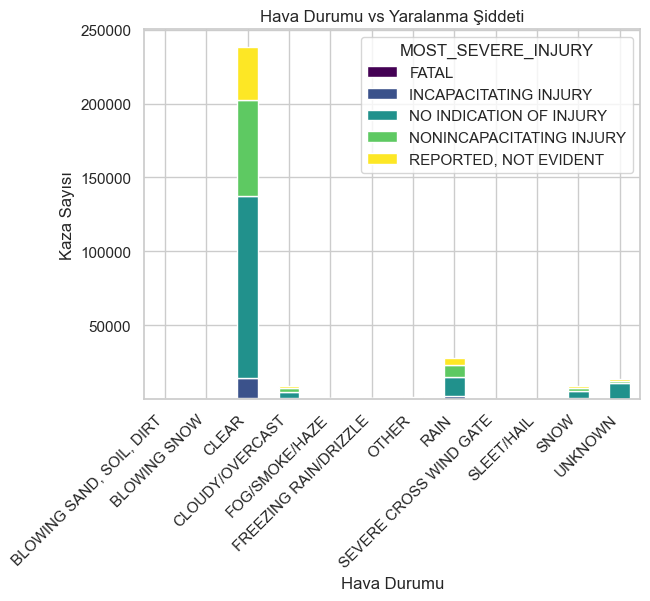

In [17]:
# WEATHER_CONDITION vs MOST_SEVERE_INJURY
plt.figure(figsize=(20,6))
cross = df.groupby(['WEATHER_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
cross.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Hava Durumu vs Yaralanma Şiddeti")
plt.xlabel("Hava Durumu")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45, ha='right')
plt.show()

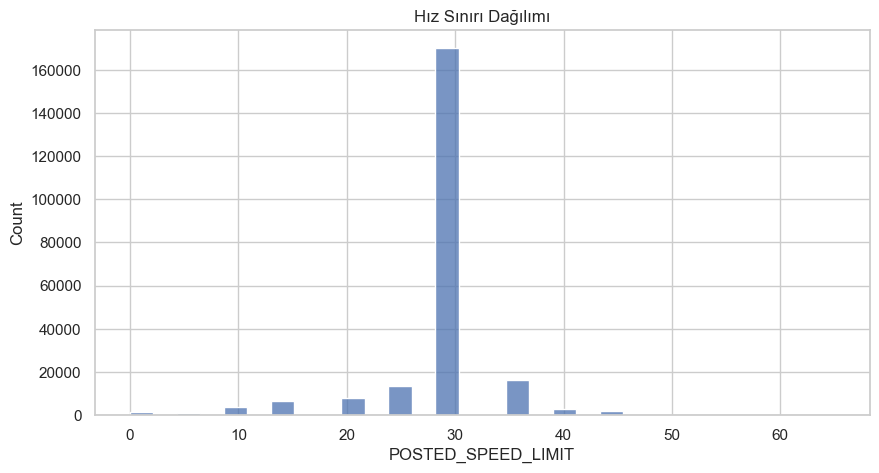

In [18]:
# Hız sınırı grafiği
plt.figure(figsize=(10,5))
sns.histplot(X_train['POSTED_SPEED_LIMIT'], bins=30)
plt.title("Hız Sınırı Dağılımı")
plt.show()

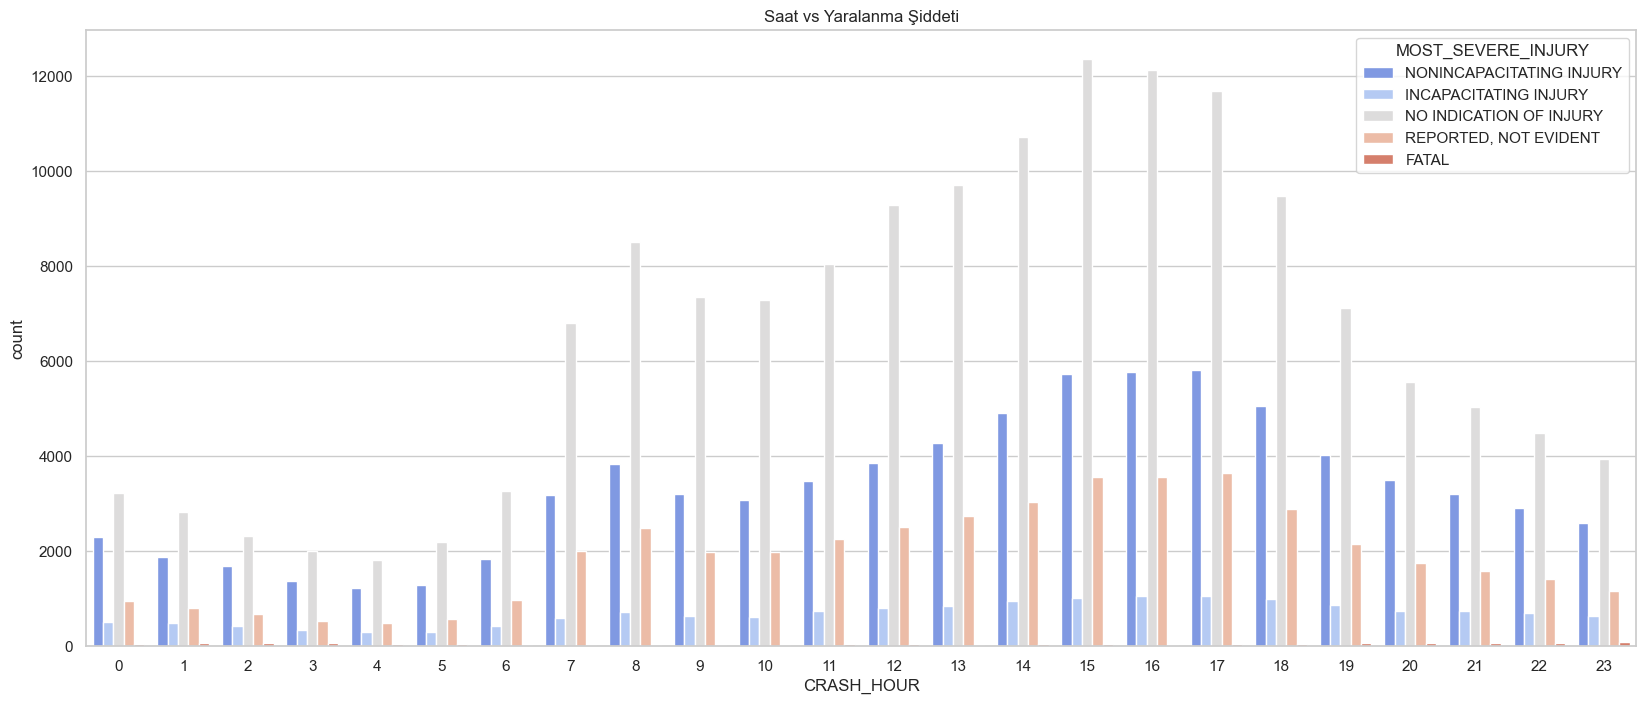

In [19]:
plt.figure(figsize=(20, 8))
sns.countplot(x='CRASH_HOUR', hue='MOST_SEVERE_INJURY', data=df, palette='coolwarm')
plt.title("Saat vs Yaralanma Şiddeti")
plt.show()


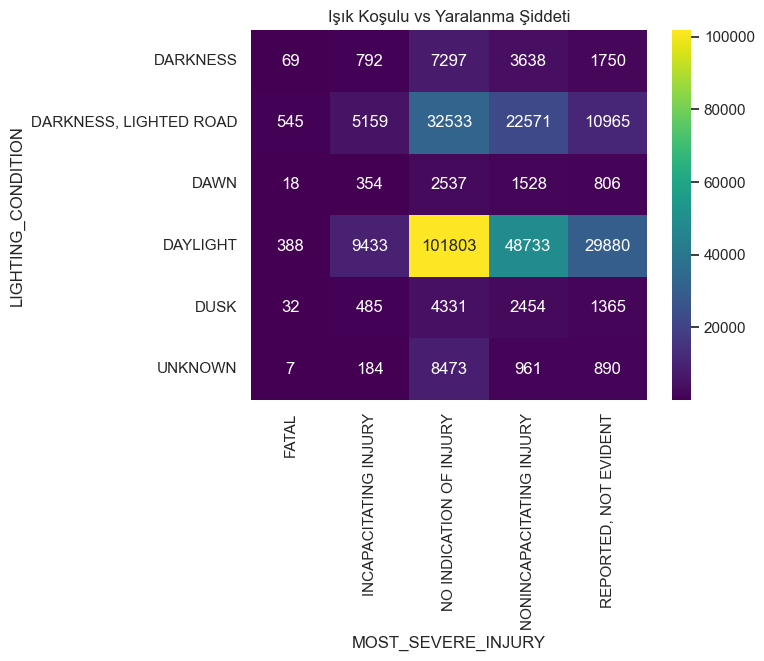

In [20]:
cross = df.groupby(['LIGHTING_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
sns.heatmap(cross, annot=True, fmt='d', cmap='viridis')
plt.title("Işık Koşulu vs Yaralanma Şiddeti")
plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# sayısal ve kategorik sütunları belirlenmesi
sayisal_sutunlar = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()
# Hedef değişken sayısal listeden çıkarılıyor
if 'MOST_SEVERE_INJURY' in sayisal_sutunlar:
    sayisal_sutunlar.remove('MOST_SEVERE_INJURY')
if 'MOST_SEVERE_INJURY' in kategorik_sutunlar:
    kategorik_sutunlar.remove('MOST_SEVERE_INJURY')

print("Sayısal sütun sayısı:", len(sayisal_sutunlar))
print("Kategorik sütun sayısı:", len(kategorik_sutunlar))


Sayısal sütun sayısı: 5
Kategorik sütun sayısı: 13


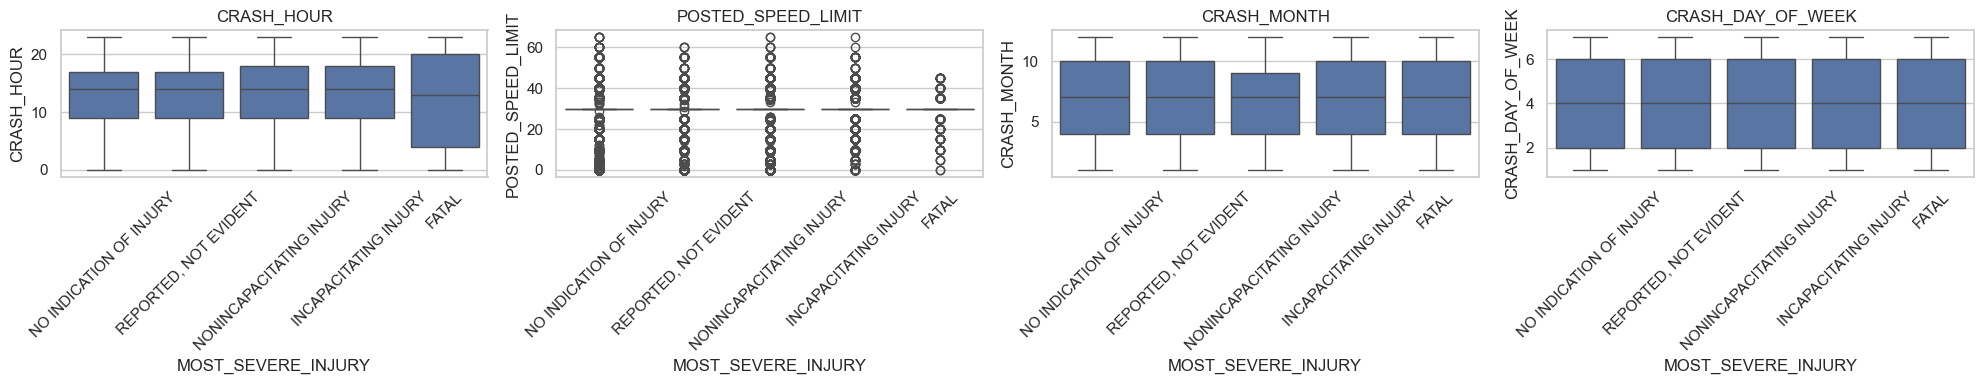

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_box_df = X_train.copy()
train_box_df["MOST_SEVERE_INJURY"] = y_train.values 

num_cols = train_box_df.select_dtypes(include=[np.number]).columns

var_series = train_box_df[num_cols].var().sort_values(ascending=False)
top_num_for_box = var_series.head(4).index

fig, axes = plt.subplots(1, len(top_num_for_box), figsize=(5 * len(top_num_for_box), 4))
if len(top_num_for_box) == 1:
    axes = [axes]

for ax, col in zip(axes, top_num_for_box):
    sns.boxplot(data=train_box_df, x="MOST_SEVERE_INJURY", y=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

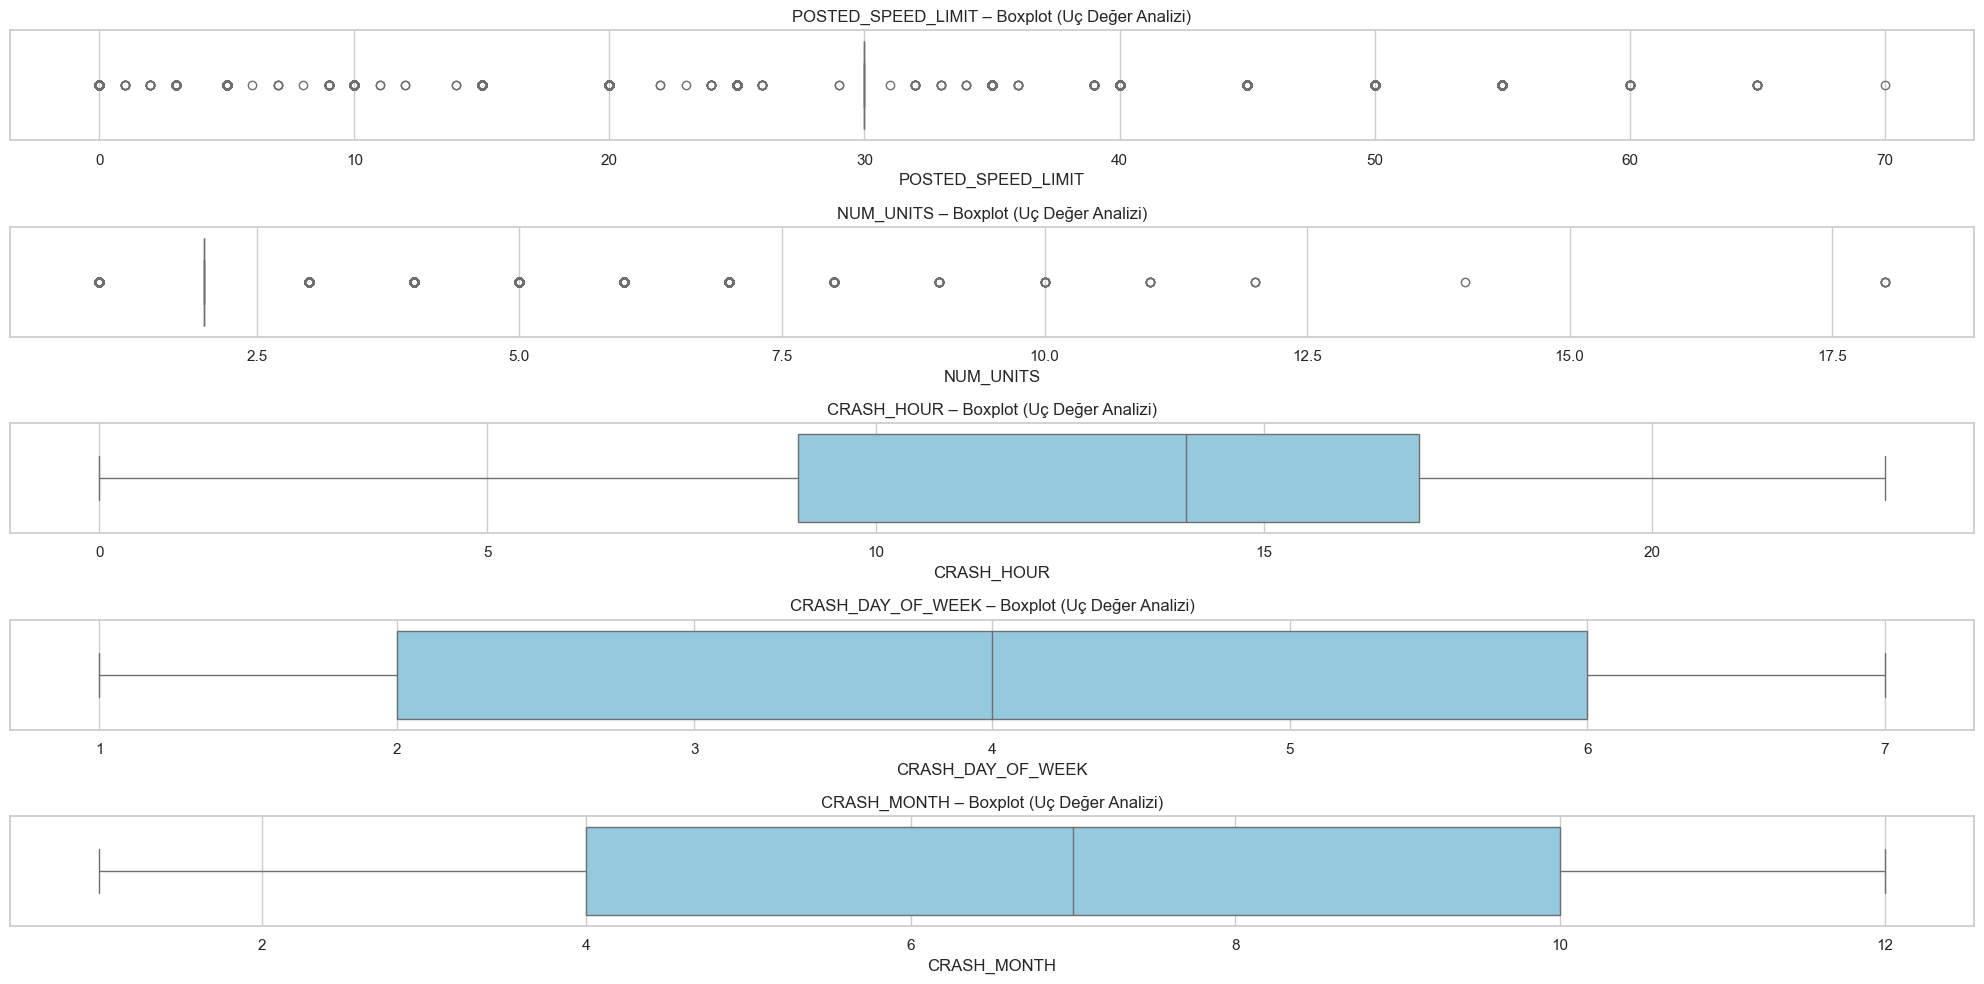

In [23]:
#SAYISAL SÜTUNLAR – UÇ DEĞER ANALİZİ
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} – Boxplot (Uç Değer Analizi)", fontsize=12)

plt.tight_layout()
plt.show()

In [24]:
# 5. Aykırı Değerleri Belirleme
outlier_report = {}
num_cols = X_train.select_dtypes(include=[np.number]).columns
for c in num_cols:
    q1 = X_train[c].quantile(0.25)
    q3 = X_train[c].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_rate = ((X_train[c] < lower) | (X_train[c] > upper)).mean() * 100
    outlier_report[c] = round(outlier_rate, 2)

outlier_df = pd.DataFrame(list(outlier_report.items()), columns=["Sütun", "Aykırı Değer Oranı (%)"])
outlier_df = outlier_df.sort_values(by="Aykırı Değer Oranı (%)", ascending=False)

print("\nAykırı değer oranı en yüksek sütunlar:")
print(outlier_df.head(10))


Aykırı değer oranı en yüksek sütunlar:
                Sütun  Aykırı Değer Oranı (%)
0  POSTED_SPEED_LIMIT                   24.46
1           NUM_UNITS                   15.27
2          CRASH_HOUR                    0.00
3   CRASH_DAY_OF_WEEK                    0.00
4         CRASH_MONTH                    0.00


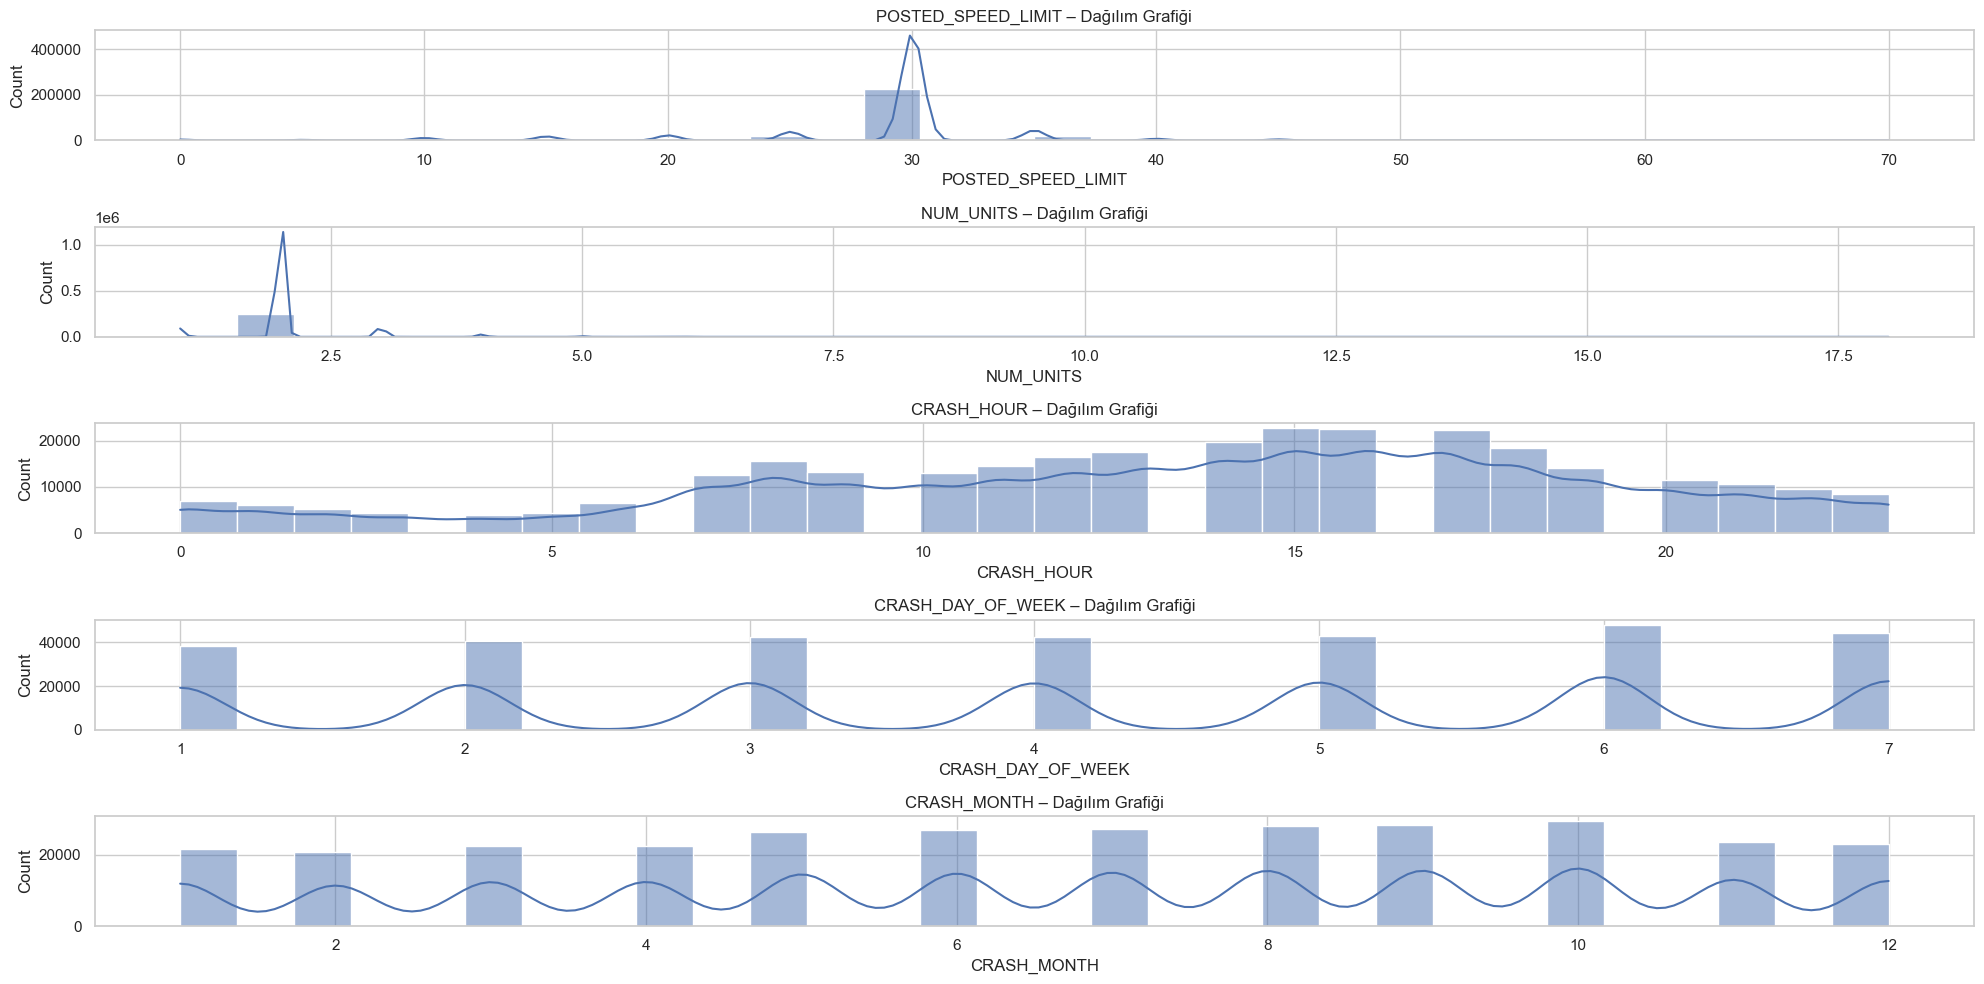

In [25]:
#SAYISAL DEĞİŞKENLERİN DAĞILIMI 
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} – Dağılım Grafiği", fontsize=12)

plt.tight_layout()
plt.show()

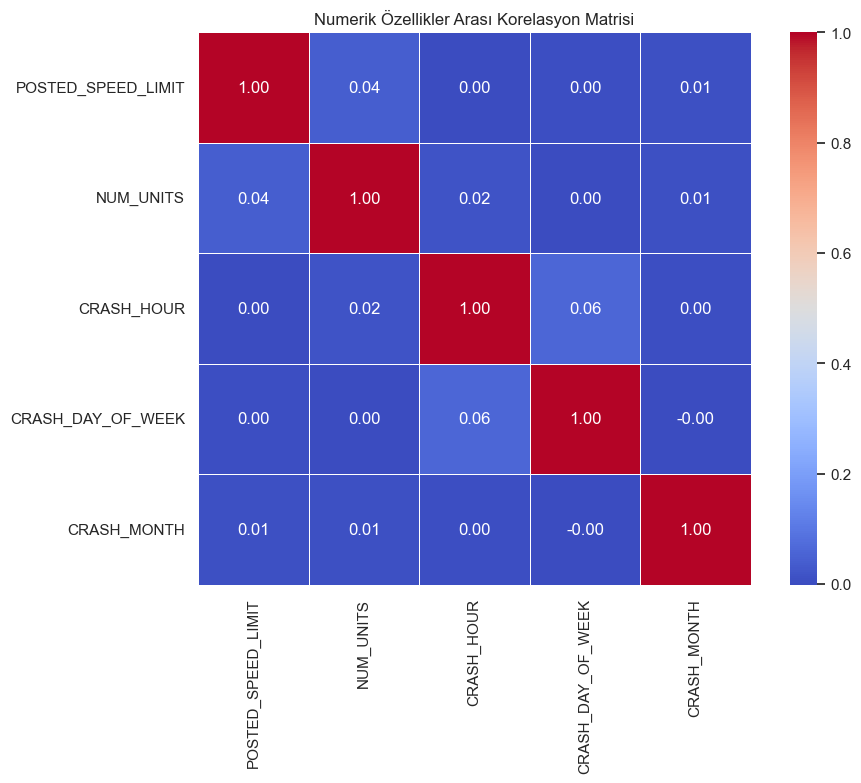

In [26]:
# =========================
# Amaç:
# - Numerik sütunların birbirleriyle olan ilişkisini (korelasyon) görmek
# - Çok güçlü ilişkili (yüksek korelasyonlu) değişkenleri tespit etmek
# - Gereksiz (birbirini tekrar eden) özellik olup olmadığını anlamak

# 1) Sadece numerik sütunları al
X_train_num_corr = X_train[sayisal_sutunlar].copy()

# 2) Korelasyon matrisi hesapla (varsayılan = Pearson)
corr_matrix = X_train_num_corr.corr()

# 3) Korelasyon matrisini görselleştir (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # Hücrelere korelasyon değerini yaz
    fmt=".2f",            # 2 basamak göster
    cmap="coolwarm",      # Renk paleti
    square=True,
    linewidths=0.5
)
plt.title("Numerik Özellikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()

In [27]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299981 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   POSTED_SPEED_LIMIT       299981 non-null  int64 
 1   TRAFFIC_CONTROL_DEVICE   299981 non-null  object
 2   DEVICE_CONDITION         299981 non-null  object
 3   WEATHER_CONDITION        299981 non-null  object
 4   LIGHTING_CONDITION       299981 non-null  object
 5   FIRST_CRASH_TYPE         299981 non-null  object
 6   TRAFFICWAY_TYPE          299981 non-null  object
 7   ALIGNMENT                299981 non-null  object
 8   ROADWAY_SURFACE_COND     299981 non-null  object
 9   ROAD_DEFECT              299981 non-null  object
 10  CRASH_TYPE               299981 non-null  object
 11  DAMAGE                   299981 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  299981 non-null  object
 13  SEC_CONTRIBUTORY_CAUSE   299981 non-null  object
 14  NUM_UNITS                

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Trafik kazalarında yaralanma şiddeti tahmini için gelişmiş Feature Engineering sınıfı.
    - CRASH_HOUR'dan gece/gündüz, yoğun saat, saat grubu üretir
    - POSTED_SPEED_LIMIT'ten hız kategorisi çıkarır
    - Hava durumu, ışık durumu gibi kategorikleri düzenler
    - Hafta sonu, iş günü gibi binary özellik oluşturur
    """
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()

        # -------------------------------
        # 1) Saat Temelli Özellikler
        # -------------------------------
        if 'CRASH_HOUR' in X_.columns:

            # Rush Hour (trafik yoğun saatleri)
            rush_hours = [6,7,8,9,16,17,18,19]
            X_['RUSH_HOUR'] = X_['CRASH_HOUR'].isin(rush_hours).astype(int)

            # Night crash (gece kazası)
            X_['NIGHT_CRASH'] = ((X_['CRASH_HOUR'] >= 20) | (X_['CRASH_HOUR'] <= 5)).astype(int)

            # Hour bin (4 gruba ayır)
            X_['HOUR_BIN'] = pd.cut(
                X_['CRASH_HOUR'],
                bins=[-1,5,11,17,23],
                labels=['Night','Morning','Afternoon','Evening']
            ).astype(str)

        # -------------------------------
        # 2) Gün Temelli Özellikler
        # -------------------------------
        if 'CRASH_DAY_OF_WEEK' in X_.columns:

            # Weekday (1=Mon, 7=Sun → 1-5 iş günü)
            X_['WEEKDAY'] = X_['CRASH_DAY_OF_WEEK'].between(2,6).astype(int)

            # Weekend
            X_['WEEKEND'] = X_['CRASH_DAY_OF_WEEK'].isin([1,7]).astype(int)

        # -------------------------------
        # 3) Hız Limiti Özellikleri
        # -------------------------------
        if 'POSTED_SPEED_LIMIT' in X_.columns:

            # Speed bin
            X_['SPEED_BIN'] = pd.cut(
                X_['POSTED_SPEED_LIMIT'],
                bins=[-1,20,30,40,50,60,70,100],
                labels=['0-20','21-30','31-40','41-50','51-60','61-70','70+']
            ).astype(str)

            # High speed flag (tehlikeli kategoriler)
            X_['HIGH_SPEED'] = (X_['POSTED_SPEED_LIMIT'] >= 50).astype(int)

        # -------------------------------
        # 4) Hava Durumu Basitleştirme
        # -------------------------------
        if 'WEATHER_CONDITION' in X_.columns:

            X_['WEATHER_SIMPLE'] = X_['WEATHER_CONDITION'].replace({
                'CLEAR': 'CLEAR',
                'CLOUDY': 'CLOUDY',
                'RAIN': 'RAIN',
                'SNOW': 'SNOW',
                'FOG/SMOKE/HAZE': 'FOG',
                'FREEZING RAIN/DRIZZLE': 'ICE',
                'OTHER': 'OTHER',
                'UNKNOWN': 'OTHER'
            })

        # -------------------------------
        # 5) Işık Koşulu Basitleştirme
        # -------------------------------
        if 'LIGHTING_CONDITION' in X_.columns:

            X_['LIGHT_SIMPLE'] = X_['LIGHTING_CONDITION'].replace({
                'DAYLIGHT': 'DAY',
                'DARKNESS': 'NIGHT',
                'DARKNESS, LIGHTED ROAD': 'NIGHT',
                'DAWN': 'DAWN',
                'DUSK': 'DUSK',
                'UNKNOWN': 'OTHER',
                'OTHER': 'OTHER'
            })

        # -------------------------------
        # 6) Kategorik Temizleme
        # -------------------------------
        # NA -> "UNKNOWN" yap
        for col in X_.select_dtypes(include='object').columns:
            X_[col] = X_[col].fillna("UNKNOWN")

        return X_


In [29]:
# FE sonrası kolon tipleri
X_train_fe = FeatureEngineer().fit_transform(X_train)

sayisal_sutunlar_fe = X_train_fe.select_dtypes(include=['int64','float64']).columns.tolist()
kategorik_sutunlar_fe = X_train_fe.select_dtypes(include=['object']).columns.tolist()

print("Sayısal kolon sayısı:", len(sayisal_sutunlar_fe))
print("Kategorik kolon sayısı:", len(kategorik_sutunlar_fe))


Sayısal kolon sayısı: 10
Kategorik kolon sayısı: 17


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [31]:
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])


In [32]:
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, sayisal_sutunlar_fe),
    ("cat", categorical_pipe, kategorik_sutunlar_fe)
])


In [33]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("fe", FeatureEngineer()),
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=5000, class_weight="balanced"))
])


In [34]:
model.fit(X_train, y_train)


Pipeline(steps=[('fe', FeatureEngineer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH', 'RUSH_HOUR',
                                                   'NIGHT_CRASH', 'WEEKDAY',
                                                   'WEEKEND', 'HIGH_SPEED']),
                                                 ('cat',
                                                  Pipeline(steps=[...
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE',
                                                   'HOUR_BIN', 'SPEED_BIN',
                                                   'WEATHER_SIMPLE',
                                                   'LIGHT_SIMPLE'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=5000))])

In [35]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ===== VALIDATION =====
val_pred = model.predict(X_val)

print("\n====== VALIDATION SONUÇLARI ======")
print("Accuracy:", accuracy_score(y_val, val_pred))
print("Macro F1:", f1_score(y_val, val_pred, average="macro"))
print(classification_report(y_val, val_pred))

# ===== TEST =====
test_pred = model.predict(X_test)

print("\n====== TEST SONUÇLARI ======")
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Macro F1:", f1_score(y_test, test_pred, average="macro"))
print(classification_report(y_test, test_pred))



====== VALIDATION SONUÇLARI ======
Accuracy: 0.6165744382958864
Macro F1: 0.3856311161830031
                          precision    recall  f1-score   support

                   FATAL       0.02      0.72      0.05        53
   INCAPACITATING INJURY       0.15      0.25      0.19       820
 NO INDICATION OF INJURY       1.00      0.86      0.93      7849
NONINCAPACITATING INJURY       0.55      0.20      0.30      3994
   REPORTED, NOT EVIDENT       0.38      0.62      0.47      2283

                accuracy                           0.62     14999
               macro avg       0.42      0.53      0.39     14999
            weighted avg       0.74      0.62      0.65     14999


====== TEST SONUÇLARI ======
Accuracy: 0.6108805440272014
Macro F1: 0.3817031977762918
                          precision    recall  f1-score   support

                   FATAL       0.02      0.63      0.04       212
   INCAPACITATING INJURY       0.14      0.24      0.18      3282
 NO INDICATION OF INJU

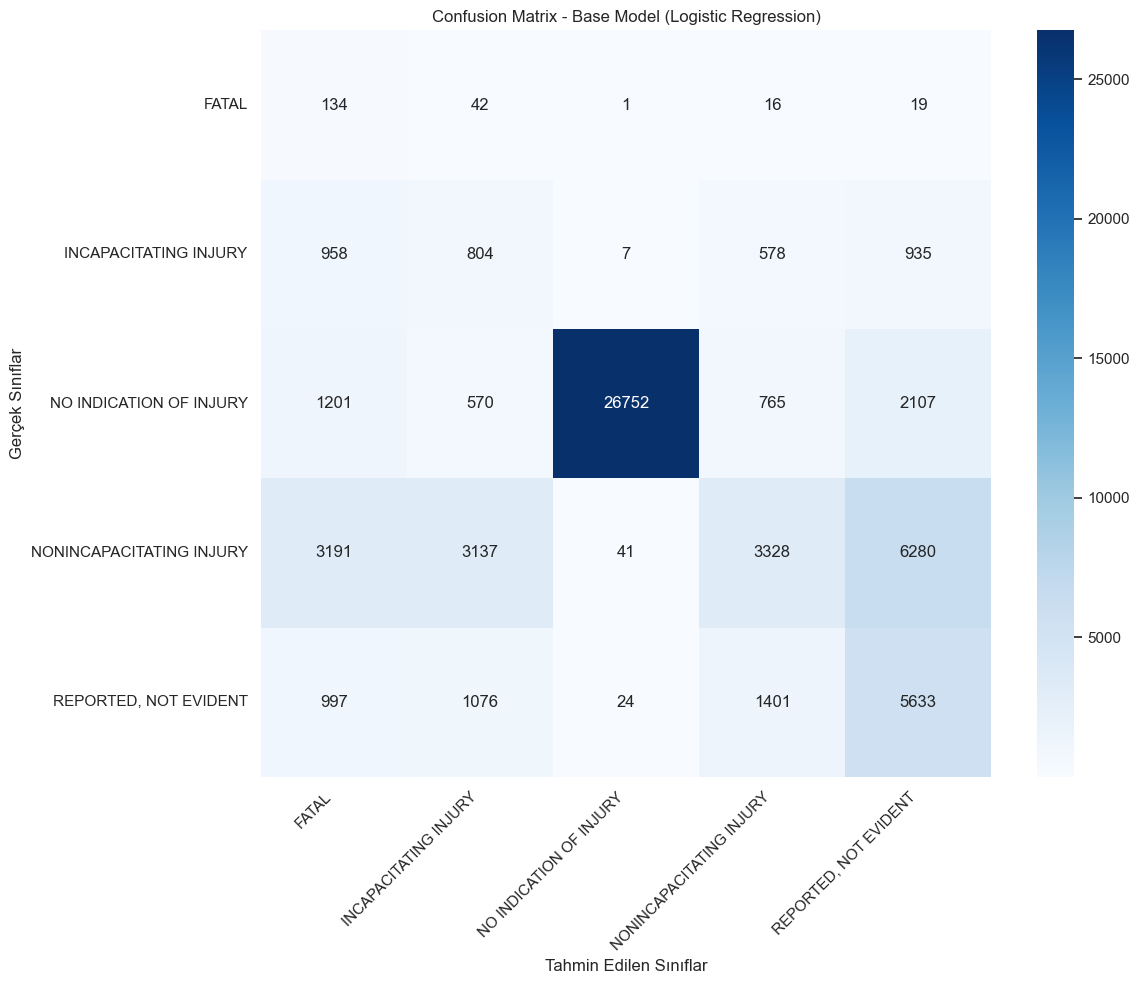

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline'daki sınıf etiketleri
class_labels = model.classes_

# Confusion matrix
cm = confusion_matrix(y_test, test_pred, labels=class_labels)

# Görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title("Confusion Matrix - Base Model (Logistic Regression)")
plt.ylabel("Gerçek Sınıflar")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [37]:
print("FEATURE SELECTION (MI)")

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

pipeline_fs = Pipeline(steps=[
    ('fe', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(
        score_func=mutual_info_classif,
        k=50
    )),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

pipeline_fs.fit(X_train, y_train)
y_pred_fs = pipeline_fs.predict(X_test)

print("\n--- FEATURE SELECTION (MI)SONUÇLARI ---")
print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("Weighted F1 Score:", f1_score(y_test, y_pred_fs, average='weighted'))
print(classification_report(y_test, y_pred_fs))


FEATURE SELECTION (MI)

--- FEATURE SELECTION (MI)SONUÇLARI ---
Accuracy: 0.6421154391052886
Weighted F1 Score: 0.6620871844101215
                          precision    recall  f1-score   support

                   FATAL       0.02      0.08      0.03       212
   INCAPACITATING INJURY       0.12      0.23      0.16      3282
 NO INDICATION OF INJURY       0.94      0.87      0.91     31395
NONINCAPACITATING INJURY       0.51      0.42      0.46     15977
   REPORTED, NOT EVIDENT       0.34      0.41      0.38      9131

                accuracy                           0.64     59997
               macro avg       0.39      0.40      0.39     59997
            weighted avg       0.69      0.64      0.66     59997



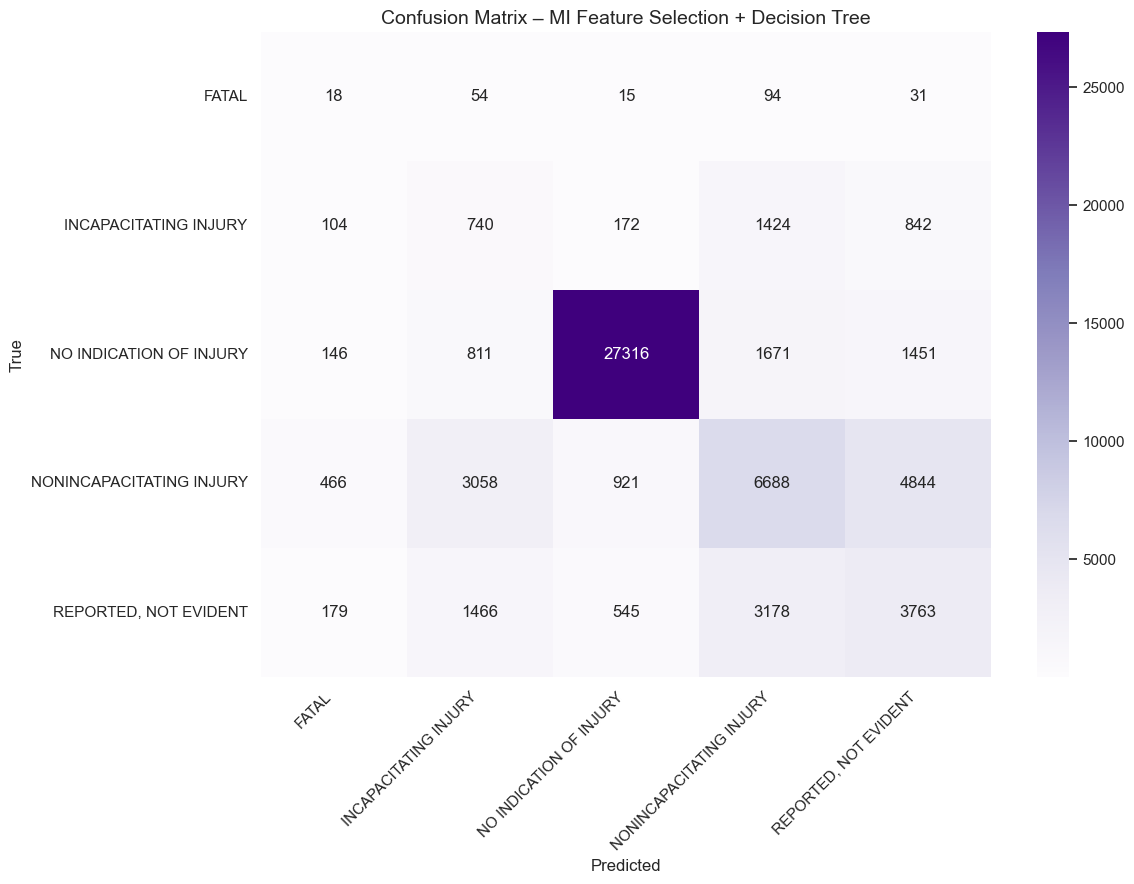

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline içindeki sınıf etiketlerini al
class_labels = pipeline_fs.classes_

# Confusion Matrix hesapla
cm_fs = confusion_matrix(y_test, y_pred_fs, labels=class_labels)

# Görselleştir
plt.figure(figsize=(12, 9))
sns.heatmap(cm_fs, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title("Confusion Matrix – MI Feature Selection + Decision Tree", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [39]:
print("DIMENSION REDUCTION (SVD)")

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

pipeline_dr = Pipeline(steps=[
    ('fe', FeatureEngineer()),                 # Feature Engineering - 
    ('preprocessor', preprocessor),            # Preprocessing - 
    ('dim_reduction', TruncatedSVD(            # Dimension Reduction (SVD)
        n_components=50,
        random_state=42
    )),
    ('classifier', DecisionTreeClassifier(      # Decision Tree Model
        random_state=42,
        class_weight='balanced'
    ))
])

# Modeli eğit
pipeline_dr.fit(X_train, y_train)

# Tahmin yap
y_pred_dr = pipeline_dr.predict(X_test)

# SONUÇLAR
print("\nDIMENSION REDUCTION (SVD)")
print("Accuracy:", accuracy_score(y_test, y_pred_dr))
print("Weighted F1 Score:", f1_score(y_test, y_pred_dr, average='weighted'))
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred_dr))


DIMENSION REDUCTION (SVD)

DIMENSION REDUCTION (SVD)
Accuracy: 0.6361484740903712
Weighted F1 Score: 0.6381622285252709

Sınıflandırma Raporu:

                          precision    recall  f1-score   support

                   FATAL       0.02      0.03      0.03       212
   INCAPACITATING INJURY       0.11      0.13      0.12      3282
 NO INDICATION OF INJURY       0.87      0.87      0.87     31395
NONINCAPACITATING INJURY       0.49      0.48      0.48     15977
   REPORTED, NOT EVIDENT       0.32      0.32      0.32      9131

                accuracy                           0.64     59997
               macro avg       0.36      0.36      0.36     59997
            weighted avg       0.64      0.64      0.64     59997



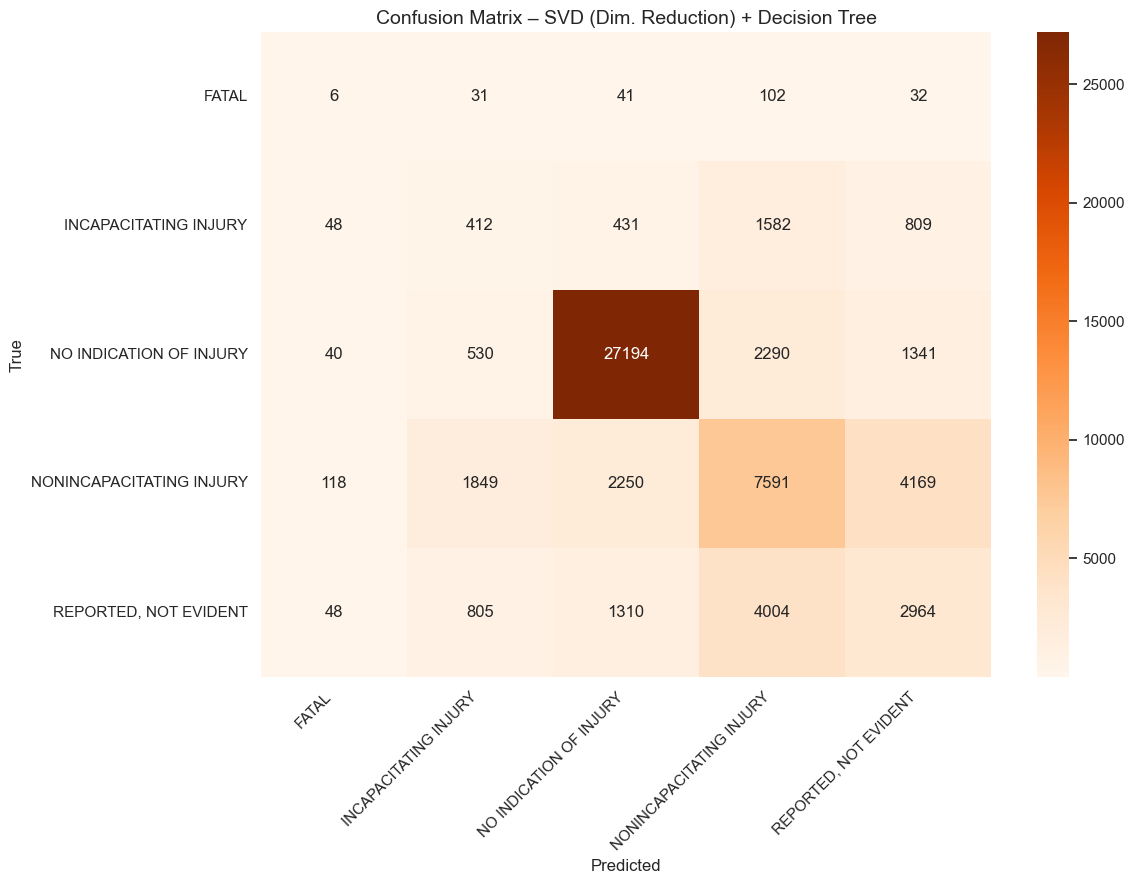

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline içindeki sınıf sırasını al
class_labels = pipeline_dr.classes_

# Confusion matrix hesapla
cm_dr = confusion_matrix(y_test, y_pred_dr, labels=class_labels)

# Görselleştir
plt.figure(figsize=(12, 9))
sns.heatmap(cm_dr, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title("Confusion Matrix – SVD (Dim. Reduction) + Decision Tree", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



--- Hafıza Taranıyor ---

BULUNDU → Base Model: 'test_pred' kullanıldı.

BULUNDU → Feature Selection (MI): 'y_pred_fs' kullanıldı.

BULUNDU → Dim. Reduction (SVD): 'y_pred_dr' kullanıldı.

       MODEL PERFORMANS KARŞILAŞTIRMA TABLOSU       


,Stage,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,Base Model,0.610881,0.381703,0.510873,0.416724
1,Feature Selection (MI),0.642115,0.386035,0.402233,0.387987
2,Dim. Reduction (SVD),0.636148,0.363170,0.363951,0.362663


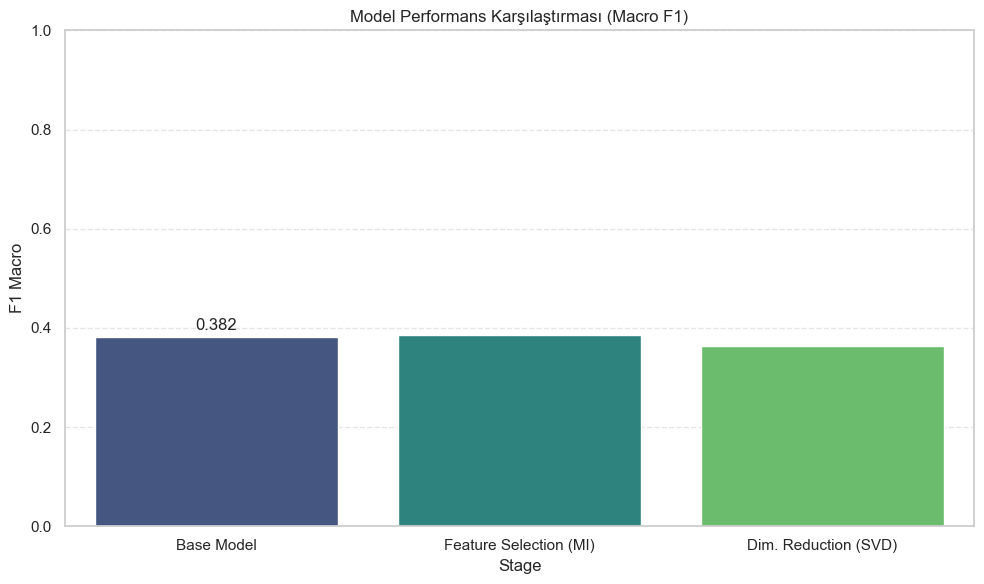

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

results_list = []

def ekle(stage_name, var_list, y_true):
    for var_name in var_list:
        if var_name in globals():
            y_pred = globals()[var_name]

            acc = accuracy_score(y_true, y_pred)
            f1  = f1_score(y_true, y_pred, average='macro')
            rec = recall_score(y_true, y_pred, average='macro')
            pre = precision_score(y_true, y_pred, average='macro')

            results_list.append({
                "Stage": stage_name,
                "Accuracy": acc,
                "F1 Macro": f1,
                "Recall Macro": rec,
                "Precision Macro": pre
            })

            print(f"BULUNDU → {stage_name}: '{var_name}' kullanıldı.\n")
            return

    print(f"BULUNAMADI → {stage_name}: Bu isimlerde bir tahmin yok.\n")


print("\n--- Hafıza Taranıyor ---\n")

# 1) BASE MODEL (bizde olabilecek tüm isimler)
ekle("Base Model", [
    "y_pred_base", "y_pred_base_dt", "y_pred_base_model",
    "test_pred", "y_pred", 
    "log_test_pred", "svc_test_pred",
    "y_pred_log", "y_pred_svc"
], y_test)

# 2) FEATURE SELECTION (MI) + DT
ekle("Feature Selection (MI)", [
    "y_pred_fs", "y_pred_fs_smote", "test_pred_fs"
], y_test)

# 3) DIM. REDUCTION (SVD) + DT
ekle("Dim. Reduction (SVD)", [
    "y_pred_dr", "y_pred_dr_smote", "test_pred_dr"
], y_test)


# Tablo ve grafik
if results_list:
    results_df = pd.DataFrame(results_list)

    print("="*50)
    print("       MODEL PERFORMANS KARŞILAŞTIRMA TABLOSU       ")
    print("="*50)
    try:
        display(results_df)
    except:
        print(results_df.to_string(index=False))

    plt.figure(figsize=(10,6))
    ax = sns.barplot(x="Stage", y="F1 Macro", data=results_df, palette="viridis")
    ax.bar_label(ax.containers[0], fmt="%.3f", padding=3)

    plt.title("Model Performans Karşılaştırması (Macro F1)")
    plt.ylim(0,1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Hiç model tahmini bulunamadı. Kernel reset yaptıysan modelleri yeniden çalıştır.")


In [42]:
# FS ve DR için macro metriklerle uyumlu sonuçlar
def ekle(stage_name, y_pred, y_true):
    return {
        "Stage": stage_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision Macro": precision_score(y_true, y_pred, average="macro"),
        "Recall Macro": recall_score(y_true, y_pred, average="macro"),
        "F1 Macro": f1_score(y_true, y_pred, average="macro")
    }

results_list = []
results_list.append(ekle("Base Model (LogReg)", test_pred, y_test))
results_list.append(ekle("Feature Selection (MI) + DT", y_pred_fs, y_test))
results_list.append(ekle("Dim. Reduction (SVD) + DT", y_pred_dr, y_test))

results_df = pd.DataFrame(results_list)
results_df


,Stage,Accuracy,Precision Macro,Recall Macro,F1 Macro
0,Base Model (LogReg),0.610881,0.416724,0.510873,0.381703
1,Feature Selection (MI) + DT,0.642115,0.387987,0.402233,0.386035
2,Dim. Reduction (SVD) + DT,0.636148,0.362663,0.363951,0.363170


In [43]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1) FeatureEngineering sonrası veriyi üret
fe = FeatureEngineer()

X_train_fe = fe.fit_transform(X_train)
X_val_fe   = fe.transform(X_val)
X_test_fe  = fe.transform(X_test)

In [44]:
# 2) Kategorik kolon indexlerini bul (object/string olanlar)
cat_cols = X_train_fe.select_dtypes(include=["object"]).columns
cat_idx  = [X_train_fe.columns.get_loc(c) for c in cat_cols]

print("Kategorik kolon sayısı:", len(cat_cols))

Kategorik kolon sayısı: 17


In [45]:
# 3) CatBoost Pool oluştur
train_pool = Pool(X_train_fe, y_train, cat_features=cat_idx)
val_pool   = Pool(X_val_fe, y_val, cat_features=cat_idx)
test_pool  = Pool(X_test_fe, y_test, cat_features=cat_idx)

In [46]:
# 4) Model
cb = CatBoostClassifier(
    iterations=800,
    learning_rate=0.1,
    depth=8,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    auto_class_weights="Balanced",
    random_seed=42,
    verbose=100
)

In [47]:
# 5) Fit (early stopping de ekledim)
cb.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)

0:	learn: 0.3794426	test: 0.3720208	best: 0.3720208 (0)	total: 25.8s	remaining: 5h 43m 35s
100:	learn: 0.5280826	test: 0.5295891	best: 0.5301098 (79)	total: 43m 21s	remaining: 5h 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5351489423
bestIteration = 111

Shrink model to first 112 iterations.


In [48]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) CatBoost test tahmini
cat_test_pred = cb.predict(test_pool).flatten()

print("\n====== CATBOOST TEST ======")
print("Accuracy:", accuracy_score(y_test, cat_test_pred))
print("Precision (Macro):", precision_score(y_test, cat_test_pred, average="macro"))
print("Recall (Macro):", recall_score(y_test, cat_test_pred, average="macro"))
print("F1 (Macro):", f1_score(y_test, cat_test_pred, average="macro"))
print("\nClassification Report:\n")
print(classification_report(y_test, cat_test_pred))


====== CATBOOST TEST ======
Accuracy: 0.6126139640315349
Precision (Macro): 0.41638045697854364
Recall (Macro): 0.49879507960071034
F1 (Macro): 0.38421277587426883

Classification Report:

                          precision    recall  f1-score   support

                   FATAL       0.02      0.57      0.04       212
   INCAPACITATING INJURY       0.14      0.25      0.18      3282
 NO INDICATION OF INJURY       1.00      0.85      0.92     31395
NONINCAPACITATING INJURY       0.54      0.23      0.32     15977
   REPORTED, NOT EVIDENT       0.38      0.60      0.46      9131

                accuracy                           0.61     59997
               macro avg       0.42      0.50      0.38     59997
            weighted avg       0.73      0.61      0.65     59997



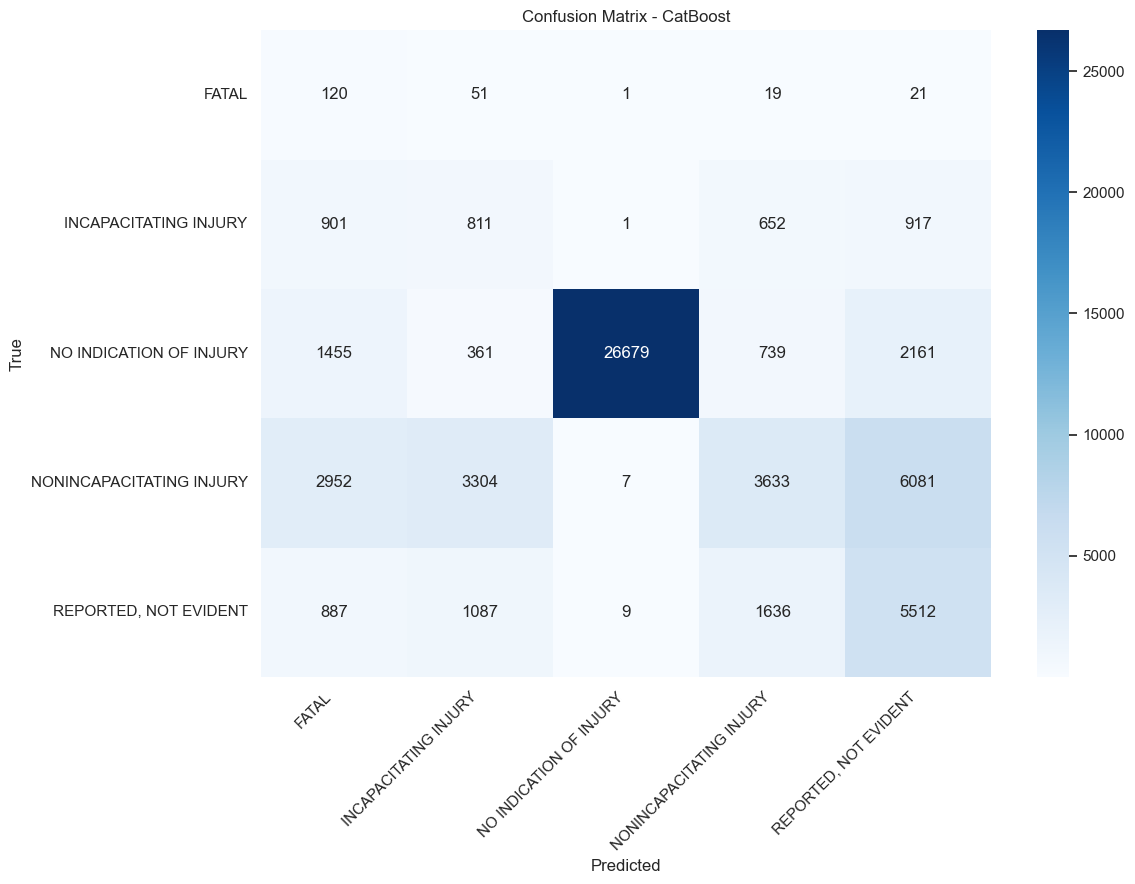

In [49]:
# 2) Confusion matrix
labels = cb.classes_ if hasattr(cb, "classes_") else sorted(y_test.unique())
cm = confusion_matrix(y_test, cat_test_pred, labels=labels)

plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)


In [51]:
# 1) MLP Pipeline
mlp_model = Pipeline([
    ("fe", FeatureEngineer()),
    ("preprocess", preprocessor),   # senin ColumnTransformer: num(imputer+scaler) + cat(imputer+OHE)
    ("model", MLPClassifier(
        hidden_layer_sizes=(128, 64),   # daha hızlı ve stabil
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        batch_size=512,                 # hız için
        max_iter=50,
        early_stopping=False,           #string label isnan hatasını engeller
        random_state=42,
        verbose=True                    # eğitim ilerlemesini görmek 
    ))
])

In [52]:
# 2) Train
mlp_model.fit(X_train, y_train)

Iteration 1, loss = 0.68701665
Iteration 2, loss = 0.63364430
Iteration 3, loss = 0.63032269
Iteration 4, loss = 0.62772795
Iteration 5, loss = 0.62564711
Iteration 6, loss = 0.62319939
Iteration 7, loss = 0.62127816
Iteration 8, loss = 0.61897475
Iteration 9, loss = 0.61670451
Iteration 10, loss = 0.61463624
Iteration 11, loss = 0.61238758
Iteration 12, loss = 0.61010146
Iteration 13, loss = 0.60833419
Iteration 14, loss = 0.60629481
Iteration 15, loss = 0.60401023
Iteration 16, loss = 0.60198941
Iteration 17, loss = 0.60028647
Iteration 18, loss = 0.59821975
Iteration 19, loss = 0.59584375
Iteration 20, loss = 0.59389471
Iteration 21, loss = 0.59218324
Iteration 22, loss = 0.59015178
Iteration 23, loss = 0.58820900
Iteration 24, loss = 0.58667168
Iteration 25, loss = 0.58473528
Iteration 26, loss = 0.58293977
Iteration 27, loss = 0.58140113
Iteration 28, loss = 0.57995835
Iteration 29, loss = 0.57840749
Iteration 30, loss = 0.57640073
Iteration 31, loss = 0.57506362
Iteration 32, los

Pipeline(steps=[('fe', FeatureEngineer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH', 'RUSH_HOUR',
                                                   'NIGHT_CRASH', 'WEEKDAY',
                                                   'WEEKEND', 'HIGH_SPEED']),
                                                 ('cat',
                                                  Pipeline(steps=[...
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE',
                                                   'HOUR_BIN', 'SPEED_BIN',
                                                   'WEATHER_SIMPLE',
                                                   'LIGHT_SIMPLE'])])),
                ('model',
                 MLPClassifier(batch_size=512, hidden_layer_sizes=(128, 64),
                               max_iter=50, random_state=42, verbose=True))])

In [53]:
# 3) Validation
mlp_val_pred = mlp_model.predict(X_val)

print("\n====== MLP VALIDATION ======")
print("Accuracy:", accuracy_score(y_val, mlp_val_pred))
print("Precision (Macro):", precision_score(y_val, mlp_val_pred, average="macro"))
print("Recall (Macro):", recall_score(y_val, mlp_val_pred, average="macro"))
print("F1 (Macro):", f1_score(y_val, mlp_val_pred, average="macro"))
print("\nClassification Report (VAL):\n")
print(classification_report(y_val, mlp_val_pred))


====== MLP VALIDATION ======
Accuracy: 0.7092472831522102
Precision (Macro): 0.4087511623367413
Recall (Macro): 0.39206082786564667
F1 (Macro): 0.3838298223959308

Classification Report (VAL):

                          precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        53
   INCAPACITATING INJURY       0.18      0.03      0.05       820
 NO INDICATION OF INJURY       0.95      0.89      0.92      7849
NONINCAPACITATING INJURY       0.51      0.74      0.60      3994
   REPORTED, NOT EVIDENT       0.41      0.30      0.35      2283

                accuracy                           0.71     14999
               macro avg       0.41      0.39      0.38     14999
            weighted avg       0.70      0.71      0.70     14999



In [54]:
# 4) Test
mlp_test_pred = mlp_model.predict(X_test)

print("\n====== MLP TEST ======")
print("Accuracy:", accuracy_score(y_test, mlp_test_pred))
print("Precision (Macro):", precision_score(y_test, mlp_test_pred, average="macro"))
print("Recall (Macro):", recall_score(y_test, mlp_test_pred, average="macro"))
print("F1 (Macro):", f1_score(y_test, mlp_test_pred, average="macro"))
print("\nClassification Report (TEST):\n")
print(classification_report(y_test, mlp_test_pred))


====== MLP TEST ======
Accuracy: 0.7111855592779639
Precision (Macro): 0.4256083772947415
Recall (Macro): 0.3978331389314801
F1 (Macro): 0.3904908243591886

Classification Report (TEST):

                          precision    recall  f1-score   support

                   FATAL       0.06      0.00      0.01       212
   INCAPACITATING INJURY       0.19      0.03      0.06      3282
 NO INDICATION OF INJURY       0.95      0.88      0.91     31395
NONINCAPACITATING INJURY       0.52      0.76      0.61     15977
   REPORTED, NOT EVIDENT       0.42      0.31      0.36      9131

                accuracy                           0.71     59997
               macro avg       0.43      0.40      0.39     59997
            weighted avg       0.71      0.71      0.70     59997



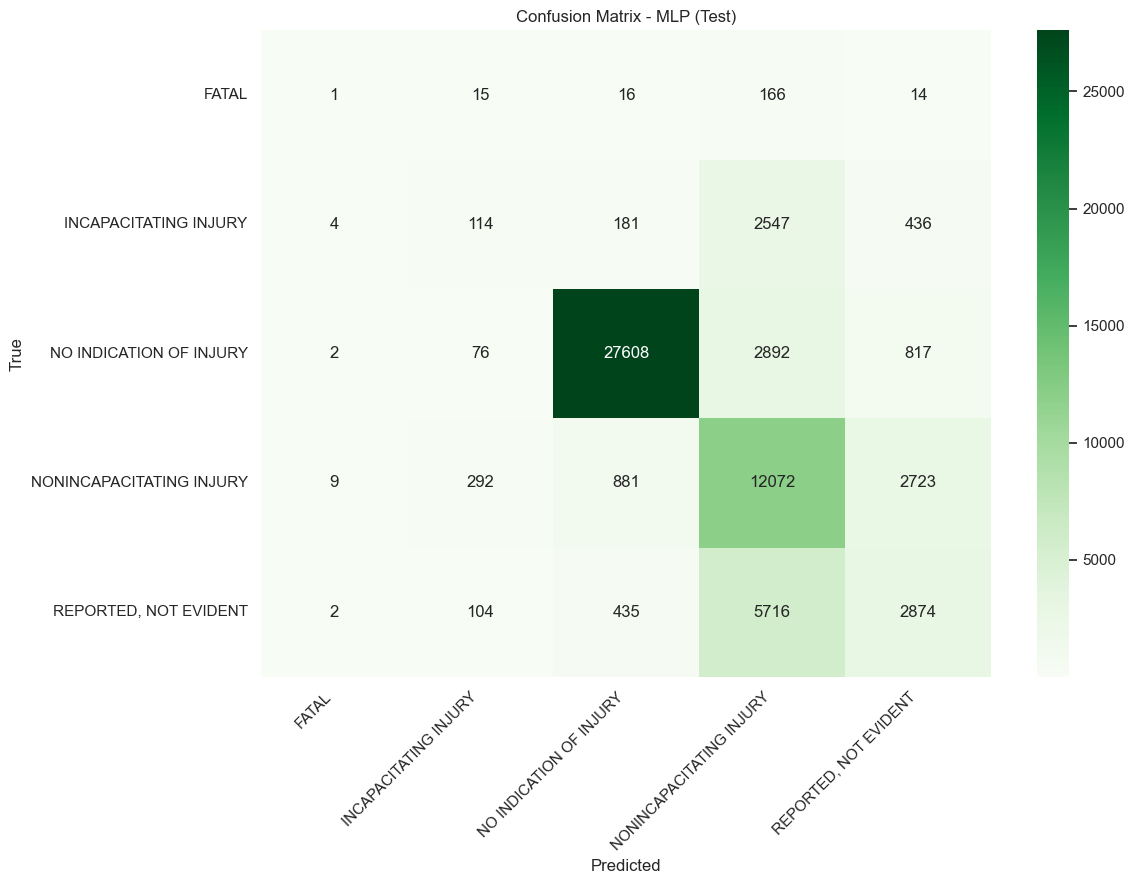

In [55]:
# 5) Confusion Matrix (TEST)
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, mlp_test_pred, labels=labels)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - MLP (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def row(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision(Macro)": precision_score(y_true, y_pred, average="macro"),
        "Recall(Macro)": recall_score(y_true, y_pred, average="macro"),
        "F1(Macro)": f1_score(y_true, y_pred, average="macro"),
    }

results_df = pd.DataFrame([
    row("CatBoost", y_test, cat_test_pred),
    row("MLP", y_test, mlp_test_pred),
]).sort_values("F1(Macro)", ascending=False)

results_df


,Model,Accuracy,Precision(Macro),Recall(Macro),F1(Macro)
1,MLP,0.711186,0.425608,0.397833,0.390491
0,CatBoost,0.612614,0.416380,0.498795,0.384213


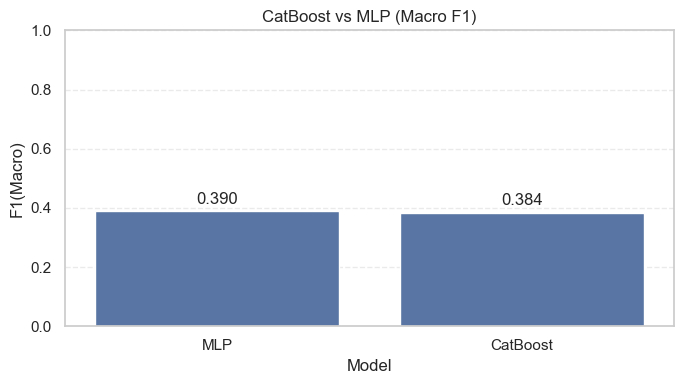

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
ax = sns.barplot(data=results_df, x="Model", y="F1(Macro)")
ax.bar_label(ax.containers[0], fmt="%.3f", padding=3)
plt.title("CatBoost vs MLP (Macro F1)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score
)

# ----------------------------
# 1) Metrik hesaplayan fonksiyon
# ----------------------------
def calc_metrics(name, y_true, y_pred, group):
    return {
        "Grup": group,  # Base / Karmaşık
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
        "Precision (Macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (Macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (Macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (Weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }

# ----------------------------
# 2) Model tahminlerini sözlükte topla
#    (Bu isimler sende üretilmiş olmalı)
# ----------------------------
preds = {
    # BASE MODELLER
    "LogReg (Base)": ("Base", test_pred),
    "MI + DecisionTree": ("Base", y_pred_fs),
    "SVD + DecisionTree": ("Base", y_pred_dr),

    # KARMAŞIK MODELLER
    "CatBoost": ("Karmaşık", cat_test_pred),
    "MLP": ("Karmaşık", mlp_test_pred),
}

# ----------------------------
# 3) Tabloyu üret
# ----------------------------
rows = []
for model_name, (group, y_pred) in preds.items():
    rows.append(calc_metrics(model_name, y_test, y_pred, group))

results_df = pd.DataFrame(rows)

# Gruplu ve F1'e göre sıralı görünüm
results_df_sorted = results_df.sort_values(
    by=["Grup", "F1 (Macro)"],
    ascending=[True, False]
).reset_index(drop=True)

results_df_sorted

,Grup,Model,Accuracy,Balanced Acc,Precision (Macro),Recall (Macro),F1 (Macro),F1 (Weighted)
0,Base,MI + DecisionTree,0.642115,0.402233,0.387987,0.402233,0.386035,0.662087
1,Base,LogReg (Base),0.610881,0.510873,0.416724,0.510873,0.381703,0.642361
2,Base,SVD + DecisionTree,0.636148,0.363951,0.362663,0.363951,0.363170,0.638162
3,Karmaşık,MLP,0.711186,0.397833,0.425608,0.397833,0.390491,0.698691
4,Karmaşık,CatBoost,0.612614,0.498795,0.416380,0.498795,0.384213,0.646567
